Originally proposed by Mikolov et al. in their influential paper "Distributed Representations of Words and Phrases and Their Compositionality", Word2Vec has become a cornerstone of natural language processing (NLP). By representing words as vectors in a high-dimensional space, Word2Vec captures both semantic (meaning-based) and syntactic (grammar-based) relationships, enabling applications like machine translation, sentiment analysis, and text similarity.

Using negative sampling—a key optimization trick introduced in the original paper—we'll efficiently train our model on large text data. Finally, we’ll evaluate the learned word vectors by finding similar words and visualizing them in 2D with t-SNE. Whether you’re new to NLP or looking for a practical introduction to Word2Vec, this notebook offers a hands-on way to understand one of the most important ideas in NLP.

# Install Dependencies

In [1]:
!pip install -q numpy requests tqdm torch scikit-learn matplotlib seaborn tabulate

# Ensure Reproducibility with Random Seeds

Many of the algorithms used in this notebook, such as sub-sampling, negative sampling, and model initialization, rely on randomness to function. While this randomness can improve efficiency and generalization, it also means that running the same code multiple times may yield slightly different results.

To ensure consistent and reproducible results across different runs of the notebook, we set random seeds for all random processes used in the code. This includes Python’s random module, NumPy, and PyTorch. By doing so, we guarantee that operations like sampling, model initialization, and training yield the same results every time the notebook is executed.

In [2]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [1]:
!nvidia-smi

Sat Jan 25 10:56:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Download and Prepare Dataset


This section downloads the text8 dataset, a pre-processed collection of Wikipedia text commonly used for language modeling. The text8 dataset is already cleaned and formatted: it contains only lowercase alphabetic characters, with punctuation, numbers, and case distinctions removed. The dataset is tokenized into words, making it ready for vocabulary construction and subsequent preprocessing steps.

In [4]:
import os
import requests
import zipfile

URL = "http://mattmahoney.net/dc/text8.zip"
FILENAME = "text8.zip"

if not os.path.isfile(FILENAME):
    response = requests.get(URL, stream=True)
    with open(FILENAME, 'wb') as file_obj:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file_obj.write(chunk)

if not os.path.isfile("text8"):
    with zipfile.ZipFile(FILENAME, 'r') as zipped_file:
        zipped_file.extractall(".")

def load_text_file():
    with open("text8", "r", encoding="utf-8") as file_obj:
        text_data = file_obj.read()
    return text_data.strip().split()

words = load_text_file()
print(words[:10])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [5]:
print(f"Number of words in the text8 dataset: {len(words)}")
print(f"Number of unique words in the text8 dataset: {len(set(words))}")

Number of words in the text8 dataset: 17005207
Number of unique words in the text8 dataset: 253854


# Build Vocabulary with Most Frequent Tokens

This section constructs a vocabulary by retaining only words that appear at least a specified number of times. Words that do not meet this frequency threshold are discarded entirely, ensuring that the vocabulary focuses on the most informative and frequently used words. This approach reduces noise and memory consumption while aligning with the Word2Vec methodology.

In [6]:
from collections import Counter

def build_vocabulary(words, min_frequency):
  word_counter = Counter(words)
  mapping = {}
  for index, (word, count) in enumerate(word_counter.most_common()):
      if count < min_frequency:
          break
      mapping[word] = index
  return mapping

In [7]:
MIN_FREQUENCY = 10

word_to_index = build_vocabulary(words, min_frequency=MIN_FREQUENCY)
index_to_word = {val: key for key, val in word_to_index.items()}
vocabluary_size = len(word_to_index)

In [8]:
words = [w for w in words if w in word_to_index]
print(f"Number of words in the text8 dataset: {len(words)}")
print(f"Number of unique words in the text8 dataset: {len(set(words))}")

Number of words in the text8 dataset: 16561031
Number of unique words in the text8 dataset: 47134


# Apply Sub-sampling to Reduce Frequent Words

To mitigate the dominance of frequent tokens, a sub-sampling technique is applied. Tokens that appear excessively often are probabilistically downsampled, ensuring a balanced dataset and enhancing the efficiency of embedding learning.

High-frequency tokens (e.g., "the", "and") have higher frequencies and therefore lower probabilities, meaning they are more likely to be skipped. Low-frequency tokens have higher probabilities and are more likely to be included.

In [10]:

def subsample_words(words, threshold):
    word_counter = Counter(words)
    total = len(words)

    def should_discard(word):
        frequency = word_counter[word] / total
        if frequency > threshold:
            p = 1 - np.sqrt(threshold / frequency)
            return random.random() < p
        return False

    return [word for word in words if not should_discard(word)]

In [11]:
THRESHOLD_FREQUENCY = 1e-5

subsampled_words = subsample_words(words, threshold=THRESHOLD_FREQUENCY)
print("Original number of words:", len(words))
print("Number of words after sub-sampling:", len(subsampled_words))

Original number of words: 16561031
Number of words after sub-sampling: 4496739


In [12]:

print(words[:20])
print(subsampled_words[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']
['anarchism', 'abuse', 'radicals', 'diggers', 'revolution', 'sans', 'revolution', 'pejorative', 'way', 'violent', 'up', 'label', 'defined', 'anarchists', 'anarchism', 'archons', 'ruler', 'chief', 'anarchism', 'rulers']


# Sub-sampling Analysis

After applying sub-sampling to reduce the dominance of high-frequency words, it's helpful to compare how many times each word appears before and after sub-sampling. The snippet below displays the first 20 words (sorted by their original frequency), along with their original and subsampled counts.

This provides a clear demonstration of how sub-sampling removes excessively frequent words while retaining less common (but potentially more informative) words.

In [13]:
from collections import Counter
from tabulate import tabulate

counts = Counter(words)
subsampled_counts = Counter(subsampled_words)

# we'll focus on the first 20 words in the dataset, sorted by original frequency (descending).
sample_words = sorted(set(words[:20]), key=lambda w: counts[w], reverse=True)

table_data = []
for w in sample_words:
    original_count = counts[w]
    after_count = subsampled_counts.get(w, 0)
    table_data.append([w, original_count, after_count])

print(tabulate(table_data, headers=["Word", "Original Count", "Subsampled Count"], tablefmt="simple"))

Word          Original Count    Subsampled Count
----------  ----------------  ------------------
the                  1061396               13047
of                    593677                9910
a                     325873                7249
as                    131815                4610
first                  28810                2208
used                   22737                1944
english                11868                1346
early                  10172                1321
including               9633                1162
against                 8432                1175
term                    7219                1070
class                   3412                 714
working                 2271                 615
originated               572                 281
abuse                    563                 304
anarchism                303                 231
radicals                 116                 116
diggers                   25                  25


# Prepare Negative Sampling Distribution

Negative sampling is a technique introduced in the Word2Vec paper to make training embeddings computationally efficient and effective. Instead of computing the gradients for all words in the vocabulary (which can be computationally expensive, especially for large vocabularies), negative sampling trains the model by updating weights for only a subset of words—specifically, a small number of "negative" (incorrect) samples for each positive (correct) context pair.

To implement negative sampling, a frequency-adjusted distribution is used. Word frequencies are raised to the power of 3/4, a "magic number" introduced in the Word2Vec paper. This adjustment downweights very common words and upweights rare ones, achieving a balance that ensures more robust embeddings by sampling negatives in a meaningful way.

In [14]:
def compute_negative_sampling_distribution(indexed_words):
    counts = np.bincount(indexed_words)
    probablility = counts / counts.sum()
    probablility_75 = probablility**0.75
    return probablility_75 / probablility_75.sum()

# Create Custom Dataset for Skip-Gram Training
A PyTorch dataset is implemented to generate training samples for the Skip-Gram model. For each target word, context words within a dynamic window and negative samples are retrieved to train the embeddings efficiently.

In [16]:
def get_target(words, index, max_window_size=5):
    window_size = random.randint(1, max_window_size)
    start_position = max(0, index - window_size)
    end_position = min(index + window_size + 1, len(words))
    return words[start_position:index] + words[index + 1:end_position]

In [17]:
get_target([i for i in range(20)], 5)

[3, 4, 6, 7]

In [18]:
get_target(subsampled_words[:20], 5)

['revolution', 'revolution']

In [19]:
from torch.utils.data import Dataset, DataLoader


class WordToVecDataset(Dataset):
    def __init__(self, indexed_words, window_size=4):
        self.indexed_words = indexed_words
        self.window_size = window_size

    def __len__(self):
        return len(self.indexed_words)

    def __getitem__(self, index):
        center_word = self.indexed_words[index]
        context_words = get_target(self.indexed_words, index, self.window_size)
        return center_word, context_words

In [20]:
dataset = WordToVecDataset(
    indexed_words=[i for i in range(20)],
    window_size=4
)

center, context = dataset[0]
print(center, context)

0 [1, 2, 3, 4]


# Implement Collate Function for Efficient Batching

This section provides a custom collate function to combine individual samples into efficient batches for training. It enables parallel processing during model training, significantly accelerating the embedding learning process.

In [21]:
import torch


def create_collate_fn(
    vocabulary_size,
    negative_sampling_distribution,
    number_of_negative_samples
):
    negative_distribution_tensor = torch.tensor(negative_sampling_distribution, dtype=torch.float)

    def collate_function(batch):
        all_center_words = []
        all_context_words = []

        # flatten out all center-context pairs
        for center_word, context_word_list in batch:
            for context_word in context_word_list:
                all_center_words.append(center_word)
                all_context_words.append(context_word)

        center_words_tensor = torch.LongTensor(all_center_words)
        context_words_tensor = torch.LongTensor(all_context_words)

        # generate negative samples for the entire batch in one shot
        total_pairs = len(center_words_tensor)
        negative_samples_flat = torch.multinomial(
            negative_distribution_tensor,
            total_pairs * number_of_negative_samples,
            replacement=True
        )

        negative_samples_tensor = negative_samples_flat.view(total_pairs, number_of_negative_samples)

        return center_words_tensor, context_words_tensor, negative_samples_tensor

    return collate_function

In [22]:

dataset = WordToVecDataset(
    indexed_words=[i for i in range(20)],
    window_size=4
)

collect_fn = create_collate_fn(20, np.full(20, 1 / 20, dtype=np.float32), 5)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collect_fn,
    drop_last=True
)

centers_tensor, contexts_tensor, negatives_tensor = next(iter(dataloader))
print(centers_tensor)
print(contexts_tensor)
print(negatives_tensor)

tensor([ 8,  8,  8,  8, 14, 14, 17, 17, 17, 17, 17, 17, 19, 19])
tensor([ 6,  7,  9, 10, 13, 15, 13, 14, 15, 16, 18, 19, 17, 18])
tensor([[19,  5, 14,  3,  1],
        [ 7, 11, 19, 19, 14],
        [ 7,  3,  0,  6, 17],
        [17, 18,  6, 10,  4],
        [ 5,  8,  3, 16, 14],
        [ 3,  1, 19, 15,  0],
        [ 1,  7, 13,  4,  3],
        [12,  4, 19,  1,  7],
        [ 8,  9, 10,  3, 17],
        [ 1,  0,  3,  5, 18],
        [14,  9,  9, 14, 19],
        [11, 18,  3,  3,  3],
        [12,  0, 19, 12, 15],
        [ 9, 17, 10, 18,  6]])


# Train Skip-Gram Model with Negative Sampling
The Skip-Gram model with negative sampling is implemented in PyTorch. By optimizing embeddings through log-sigmoid functions for positive and negative pairs, the model learns high-quality distributed word representations that capture semantic relationships.

In [23]:
import torch.nn as nn

class SkipGram(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):
        super().__init__()
        self.input_embeddings = nn.Embedding(vocabulary_size, embedding_dimension)
        self.output_embeddings = nn.Embedding(vocabulary_size, embedding_dimension)
        self.input_embeddings.weight.data.uniform_(-1, 1)
        self.output_embeddings.weight.data.uniform_(-1, 1)

    def forward(self, center_words, positive_context_words, negative_context_words):
        center_vectors = self.input_embeddings(center_words)
        positive_context_vectors = self.output_embeddings(positive_context_words)
        negative_context_vectors = self.output_embeddings(negative_context_words)

        # dot product for positive pairs => shape: [batch_size]
        positive_score = torch.einsum("ij,ij->i", center_vectors, positive_context_vectors)
        # dot product for negative pairs => shape: [batch_size, K]
        negative_score = torch.einsum("ijk,ik->ij", negative_context_vectors, center_vectors)

        positive_loss = F.logsigmoid(positive_score).mean()
        negative_loss = F.logsigmoid(-negative_score).mean()

        return -(positive_loss + negative_loss)


In [24]:
def compute_cosine_similarity(vector_one, vector_two):
    numerator = np.dot(vector_one, vector_two)
    denominator = (np.linalg.norm(vector_one) * np.linalg.norm(vector_two) + 1e-9)
    return numerator / denominator

def find_similar_words(query_word, embedding_matrix, top_count=10):
    query_index = word_to_index.get(query_word, 0)
    query_vector = embedding_matrix[query_index]
    similarities = []

    for word, index in word_to_index.items():
        if word == query_word:
            continue
        word_vector = embedding_matrix[index]
        similarity = compute_cosine_similarity(query_vector, word_vector)
        similarities.append((word, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_count]

In [25]:
def display_similar_words(model, validation_words, word_to_index, index_to_word, top_count=5):
    embedding_matrix = model.input_embeddings.weight.data.cpu().numpy()
    table_data = []

    for word in validation_words:
        similar_list = find_similar_words(word, embedding_matrix, top_count)
        similar_str = ", ".join([f"{w} ({sim:.4f})" for w, sim in similar_list])
        table_data.append([word, similar_str])

    print(tabulate(table_data, headers=["Word", "Most Similar Words"], tablefmt="simple"))

In [26]:

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from tabulate import tabulate


EMBEDDING_DIM = 300
WINDOW_SIZE = 4
NUM_NEGATIVE_SAMPLES = 5
BATCH_SIZE = 512
EPOCHS = 5
LEARNING_RATE = 0.003

In [27]:
indexed_words = [word_to_index.get(token, 0) for token in subsampled_words]
negative_sampling_distribution = compute_negative_sampling_distribution(indexed_words)


collate_function = create_collate_fn(
    vocabulary_size=vocabluary_size,
    negative_sampling_distribution=negative_sampling_distribution,
    number_of_negative_samples=NUM_NEGATIVE_SAMPLES
)

dataset = WordToVecDataset(
    indexed_words=indexed_words,
    window_size=WINDOW_SIZE
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_function,
    drop_last=True
)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipGram(vocabluary_size, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [29]:
loss_history = []

for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch+1}/{EPOCHS}")

    for step, (centers, contexts, negs) in progress_bar:
        centers, contexts, negs = centers.to(device), contexts.to(device), negs.to(device)

        optimizer.zero_grad()
        loss = model(centers, contexts, negs)
        loss.backward()
        optimizer.step()

        current_loss_value = loss.item()
        loss_history.append(current_loss_value)
        progress_bar.set_postfix({"loss": current_loss_value})

    validation_words =  [index_to_word.get(idx) for idx in random.sample(range(1, 100), 5)]
    validation_words += [index_to_word.get(idx) for idx in random.sample(range(1000, 2000), 5)]
    display_similar_words(model, validation_words, word_to_index, index_to_word)

Epoch 1/5: 100%|██████████| 8782/8782 [03:13<00:00, 45.31it/s, loss=1.5]


Word        Most Similar Words
----------  --------------------------------------------------------------------------------------------
state       government (0.4750), law (0.4328), rights (0.4267), countries (0.4266), governments (0.4062)
five        eight (0.6183), six (0.5952), seven (0.5949), four (0.5757), zero (0.5716)
all         they (0.4464), take (0.4296), them (0.4293), to (0.4224), have (0.4196)
many        such (0.4227), some (0.4179), personal (0.3927), not (0.3843), often (0.3825)
states      government (0.5594), united (0.5113), republic (0.4953), democratic (0.4869), party (0.4858)
glass       metal (0.3549), tissue (0.3183), carbon (0.3180), crystal (0.3169), ammonia (0.3128)
materials   carbon (0.3752), atoms (0.3692), less (0.3668), chemical (0.3413), are (0.3394)
medieval    roman (0.3833), church (0.3615), christian (0.3278), greek (0.3276), catholic (0.3258)
equivalent  function (0.3763), properties (0.3673), set (0.3552), inverse (0.3450), numbers (0.3391)
brin

Epoch 2/5: 100%|██████████| 8782/8782 [03:14<00:00, 45.27it/s, loss=1.25]


Word          Most Similar Words
------------  -----------------------------------------------------------------------------------------------
been          many (0.4085), modern (0.3766), evidence (0.3552), they (0.3536), claim (0.3458)
also          commonly (0.3037), the (0.3013), particular (0.2966), containing (0.2885), contains (0.2878)
six           five (0.6716), three (0.6646), four (0.6542), one (0.6536), eight (0.6528)
are           vary (0.4034), typically (0.3967), some (0.3721), consists (0.3524), populations (0.3519)
in            major (0.3329), the (0.3284), debating (0.3256), beginning (0.3223), organized (0.3148)
behind        shot (0.3347), drop (0.3314), up (0.3295), struck (0.3101), shock (0.3093)
wild          animals (0.3978), cats (0.3577), birds (0.3475), habitat (0.3471), animal (0.3335)
critics       ironically (0.3730), challenged (0.3703), fans (0.3567), accused (0.3544), argue (0.3519)
christianity  christian (0.4695), theology (0.4552), catholic (0.4463)

Epoch 3/5: 100%|██████████| 8782/8782 [03:04<00:00, 47.57it/s, loss=1.2]


Word    Most Similar Words
------  ---------------------------------------------------------------------------------------------
see     article (0.3828), disambiguation (0.3255), site (0.3238), related (0.3206), history (0.3198)
system  systems (0.4301), operating (0.3512), applications (0.3364), software (0.3359), unit (0.3244)
known   origin (0.2852), exists (0.2780), derived (0.2677), interiors (0.2576), refers (0.2545)
about   average (0.2804), ancestry (0.2733), mercator (0.2693), found (0.2690), diversity (0.2688)
from    the (0.2945), timeline (0.2702), half (0.2522), tenth (0.2460), appended (0.2439)
opened  park (0.3349), rail (0.3241), hotels (0.3217), buildings (0.3176), downtown (0.3172)
lists   list (0.4232), web (0.3439), entries (0.3230), proverbs (0.3075), weblogs (0.3044)
loss    losses (0.3766), shortages (0.3554), yield (0.3286), severe (0.3254), reduced (0.3221)
dog     dogs (0.3880), greyhound (0.3441), appear (0.3225), cat (0.3208), spaniel (0.3187)
volume  volum

Epoch 4/5: 100%|██████████| 8782/8782 [03:01<00:00, 48.30it/s, loss=1.11]


Word       Most Similar Words
---------  --------------------------------------------------------------------------------------------
will       must (0.3905), if (0.3561), doesn (0.3535), that (0.3474), hence (0.3263)
than       less (0.4089), rather (0.3339), more (0.3302), possible (0.3166), fewer (0.3163)
after      years (0.3604), temporarily (0.3560), shortly (0.3452), was (0.3325), ended (0.3261)
which      composed (0.3108), thus (0.2979), have (0.2838), to (0.2810), piece (0.2795)
as         called (0.3045), encountered (0.2800), elements (0.2760), various (0.2731), since (0.2679)
marked     occupying (0.2991), throughout (0.2869), highlight (0.2776), during (0.2710), ended (0.2697)
brothers   brother (0.3081), grammy (0.3010), went (0.2840), stepson (0.2768), cameo (0.2765)
extensive  rden (0.2776), most (0.2766), trolleybus (0.2724), barada (0.2700), inaccessible (0.2685)
actions    human (0.3985), argued (0.3742), action (0.3417), coercion (0.3327), motivated (0.3327)
gun  

Epoch 5/5: 100%|██████████| 8782/8782 [03:03<00:00, 47.89it/s, loss=1.08]


Word          Most Similar Words
------------  --------------------------------------------------------------------------------------------
s             browne (0.2683), loved (0.2648), endowed (0.2477), reynolds (0.2397), lifelong (0.2326)
four          six (0.6214), two (0.6042), one (0.5994), three (0.5837), five (0.5747)
these         are (0.3505), they (0.3115), have (0.3082), some (0.3049), exceptions (0.3003)
some          those (0.3279), that (0.3101), these (0.3049), drawbacks (0.3040), memes (0.3027)
see           disambiguation (0.3884), topics (0.3182), article (0.2972), external (0.2938), term (0.2867)
understand    know (0.3814), discern (0.3418), objectively (0.3295), how (0.3288), what (0.3184)
rich          fertile (0.2921), tomatoes (0.2876), abundant (0.2872), fresh (0.2790), kelp (0.2788)
duke          earl (0.4305), dukes (0.3974), prince (0.3858), brabant (0.3832), margrave (0.3831)
specifically  commonly (0.2537), are (0.2451), angered (0.2438), also (0.2355), s

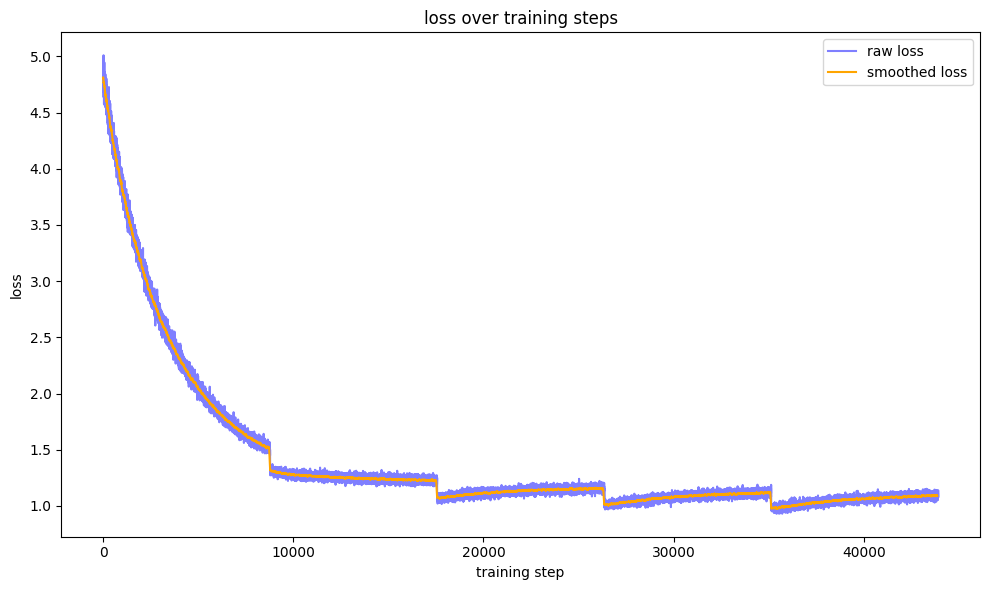

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_loss_history(loss_history, smoothing_window=50):
    smoothed_loss = np.convolve(loss_history, np.ones(smoothing_window) / smoothing_window, mode='valid')

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(loss_history)), y=loss_history, label='raw loss', color='blue', alpha=0.5)
    sns.lineplot(x=range(len(smoothed_loss)), y=smoothed_loss, label='smoothed loss', color='orange')

    plt.title("loss over training steps")
    plt.xlabel("training step")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_history(loss_history)

# Extract Trained Word Embeddings

After training, input and output embeddings are extracted from the model. These embeddings represent words in a distributed format, and optionally, input and output embeddings can be averaged to create a unified representation for each word.

In [32]:
import torch

input_embeddings = model.input_embeddings.weight.data.cpu().numpy()
output_embeddings = model.output_embeddings.weight.data.cpu().numpy()
combined_embeddings = (input_embeddings + output_embeddings) / 2.0

# Find Similar Words Using Cosine Similarity
Given a query word, this section finds the most similar words based on cosine similarity in the embedding space. This functionality allows for an evaluation of the quality and semantic relationships captured by the embeddings.

In [33]:
similar_words = find_similar_words("computer", embedding_matrix=combined_embeddings, top_count=10)
print(tabulate(similar_words, headers=["Word", "Cosine Similarity"], tablefmt="simple", floatfmt=".4f"))


Word         Cosine Similarity
---------  -------------------
computers               0.6006
software                0.4832
hardware                0.4758
computing               0.4694
machines                0.4566
emulator                0.4486
pdp                     0.4430
desktop                 0.4250
cpu                     0.4218
console                 0.4202


# Visualize Word Embeddings with t-SNE
Using t-SNE, word embeddings are reduced to two dimensions for visualization. Words are color-coded by predefined categories to highlight how well the embeddings cluster semantically similar tokens, providing insights into the model’s performance.

In [34]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_colored_embeddings_with_tsne(
    word_categories,
    embedding_matrix,
    category_colors,
    word_to_index,
    perplexity=30,
    text_offset=0.02
):

  word_to_category = {
        word: category
        for category, words in word_categories.items()
        for word in words
    }

  all_words = list(word_to_category.keys())
  valid_words = [word for word in all_words if word in word_to_index]
  word_indices = [word_to_index[word] for word in valid_words]
  vectors = embedding_matrix[word_indices]

  tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
  reduced_vectors = tsne.fit_transform(vectors)


  plt.figure(figsize=(10, 10), dpi=150)
  for i, word in enumerate(valid_words):
      category = word_to_category[word]
      color = category_colors.get(category, "black")

      x, y = reduced_vectors[i]
      plt.scatter(x, y, color=color, alpha=0.8, edgecolors='k', linewidths=0.5)

      plt.text(
          x, y + text_offset, word,
          fontsize=10,
          color="black",
          ha="center",
          va="bottom",
          bbox=dict(
              boxstyle="round,pad=0.2",
              ec="none",
              fc="white",
              alpha=0.7
          )
      )
  plt.title("word embeddings visualization", fontsize=16, pad=20)
  plt.tight_layout()
  plt.show()


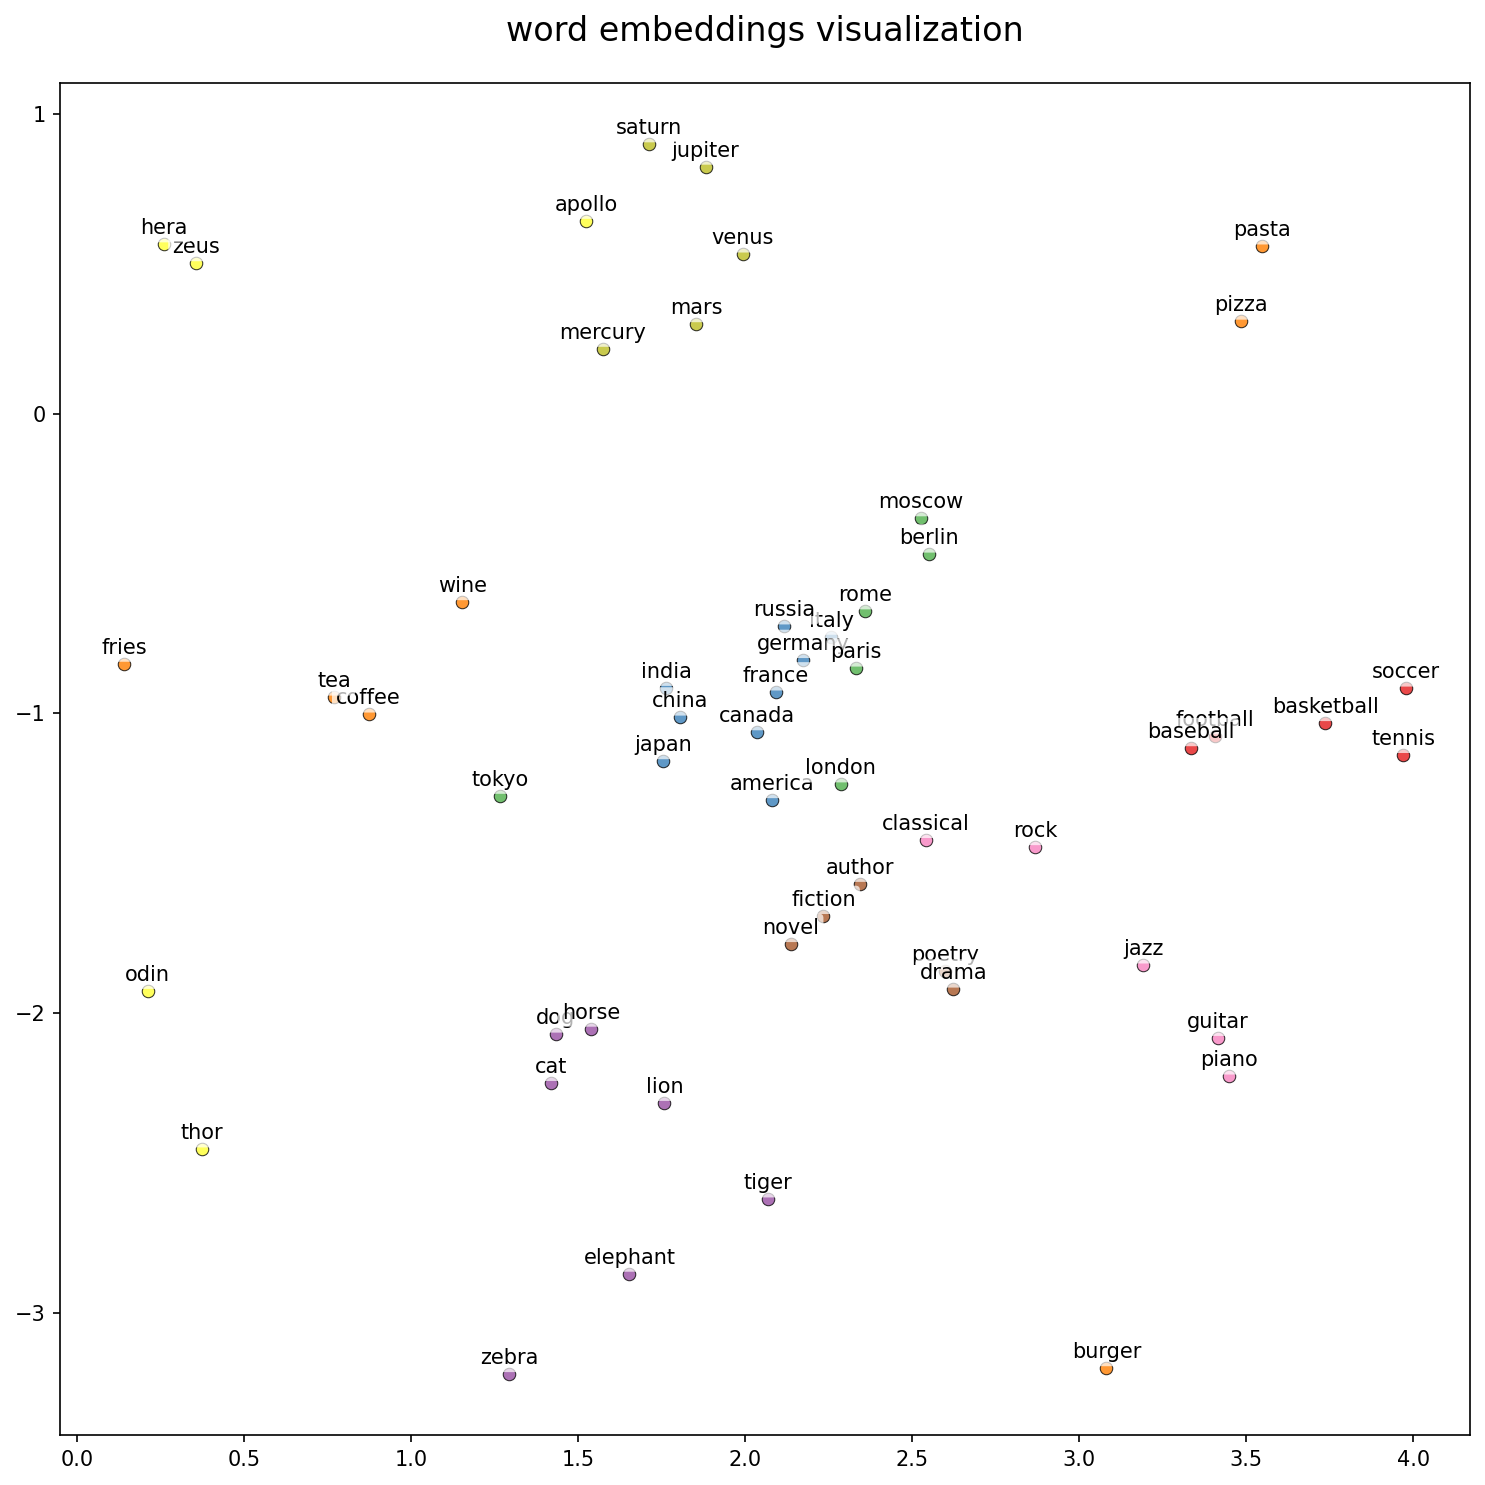

In [35]:
word_categories = {
    # Existing Categories
    "sports": ["soccer", "football", "baseball", "basketball", "tennis"],
    "countries": ["america", "canada", "france", "germany", "italy", "japan", "china", "india", "russia"],
    "cities": ["paris", "berlin", "rome", "london", "tokyo", "moscow"],
    "animals": ["dog", "cat", "horse", "elephant", "lion", "tiger", "zebra"],
    "foods": ["pizza", "pasta", "burger", "fries", "coffee", "tea", "wine"],
    "music": ["rock", "jazz", "classical", "guitar", "piano"],
    "literature": ["poetry", "novel", "author", "drama", "fiction"],
    "mythology": ["zeus", "apollo", "thor", "odin", "hera"],
    "planets": ["mars", "venus", "jupiter", "saturn", "mercury"]
}

category_colors = {
    "sports":   "#e41a1c",
    "countries": "#377eb8",
    "cities":   "#4daf4a",
    "animals":  "#984ea3",
    "foods":    "#ff7f00",
    "music": "#f781bf",
    "literature": "#a65628",
    "mythology": "#ffff33",
    "planets": "#bcbd22"
}

plot_colored_embeddings_with_tsne(
    word_categories=word_categories,
    embedding_matrix=combined_embeddings,
    category_colors=category_colors,
    word_to_index=word_to_index,
    perplexity=30,
    text_offset=0.02
)

# Learn More in the VLMs Zero-to-Hero Course